## Calculate coral bleaching using ERA5 data in the Puerto Rico regions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import netCDF4
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

### Read in preprocessed SST data and identify location

In [3]:
file = '/glade/derecho/scratch/kristenk/bleaching_work/PR_SST_timeseries_daily.nc'
ds = xr.open_dataset(file)

In [5]:
times = pd.date_range(start="1980-01-01", end="2024-12-31",freq="D")
ds['time'] = times

In [6]:
ds

<xarray.Dataset>
Dimensions:  (time: 16437)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2024-12-31
Data variables:
    SPR_sst  (time) float64 ...
    NPR_sst  (time) float64 ...

In [7]:
nday = len(ds['SPR_sst'].time)
nday

16437

### Plot SST from a subset of data

In [8]:
ds.time

<xarray.DataArray 'time' (time: 16437)>
array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ..., '2024-12-29T00:00:00.000000000',
       '2024-12-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2024-12-31

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 20.1 ms


(24.0, 31.0)

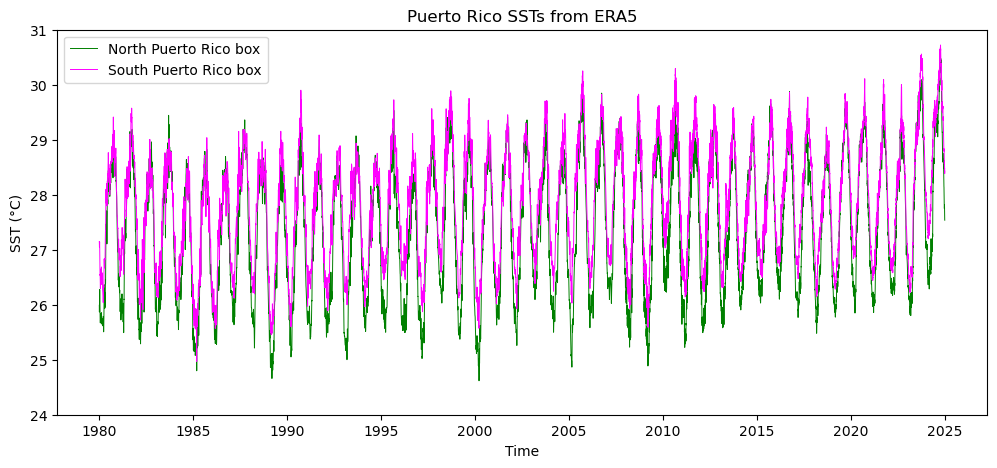

In [9]:
%%time

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Puerto Rico SSTs from ERA5')
ax.plot(ds.time, ds['NPR_sst'], linewidth=0.7, color='green',label='North Puerto Rico box')
ax.plot(ds.time, ds['SPR_sst'], linewidth=0.7, color='magenta',label='South Puerto Rico box')
ax.set(ylabel='SST (°C)',xlabel='Time')
ax.legend()
ax.set_ylim(24,31)

### Make a monthly dataset

In [10]:
ds_mon = ds.resample({'time':'M'}).mean(dim='time').compute()

In [11]:
ds_mon.time

<xarray.DataArray 'time' (time: 540)>
array(['1980-01-31T00:00:00.000000000', '1980-02-29T00:00:00.000000000',
       '1980-03-31T00:00:00.000000000', ..., '2024-10-31T00:00:00.000000000',
       '2024-11-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2024-12-31

### Calculate static climatology (Maximum monthly mean MMM temp)

### Find maximum monthly means over this period

In [12]:
### Make some empty arrays
ymax = np.zeros((10,),dtype=float) ### year maxes over climatological period
#MMM 
#MMMstd


### cycle through each year of the period of our static climatology
for y in range(0,10):

    ### find the index of the first month of this year
    m1 = y * 12 ## find the index of the first month of this year

    ### put the maximum temperature from this year into the ymax array
    ymax[y] = np.max(ds_mon.NPR_sst.values[m1:m1+12])

    print(y, ymax[y])
    
### take a mean and standard deviation of ymax values
MMM_NPR = np.mean(ymax) 
MMMstd_NPR = np.std(ymax)
    
print("For the static climatology:")
print("Max monthly mean temp is ", MMM_NPR)
print("Standard deviation of MMM is", MMMstd_NPR)

0 28.77293247470368
1 29.006599045058884
2 28.51719253575127
3 28.857773692940448
4 28.272222436707715
5 28.508834250996035
6 28.36727543110896
7 29.062035324305057
8 28.331971592235256
9 28.213564744226932
For the static climatology:
Max monthly mean temp is  28.591040152803423
Standard deviation of MMM is 0.2953452409424127


In [13]:
### Make some empty arrays
ymax = np.zeros((10,),dtype=float) ### year maxes over climatological period
#MMM 
#MMMstd


### cycle through each year of the period of our static climatology
for y in range(0,10):

    ### find the index of the first month of this year
    m1 = y * 12 ## find the index of the first month of this year

    ### put the maximum temperature from this year into the ymax array
    ymax[y] = np.max(ds_mon.SPR_sst.values[m1:m1+12])

    print(y, ymax[y])
    
### take a mean and standard deviation of ymax values
MMM_SPR = np.mean(ymax) 
MMMstd_SPR = np.std(ymax)
    
print("For the static climatology:")
print("Max monthly mean temp is ", MMM_SPR)
print("Standard deviation of MMM is", MMMstd_SPR)

0 28.895495196959935
1 29.3611949005032
2 28.55651125697888
3 28.72898456630525
4 28.244883736496796
5 28.380055674635926
6 28.296895215237353
7 29.053646154547913
8 28.47689786026298
9 28.755908316738893
For the static climatology:
Max monthly mean temp is  28.675047287866715
Standard deviation of MMM is 0.3377209460359437


### Calculate Degree Heating Months (DHW) with the daily data

https://coralreefwatch.noaa.gov/product/5km/methodology.php#dhw

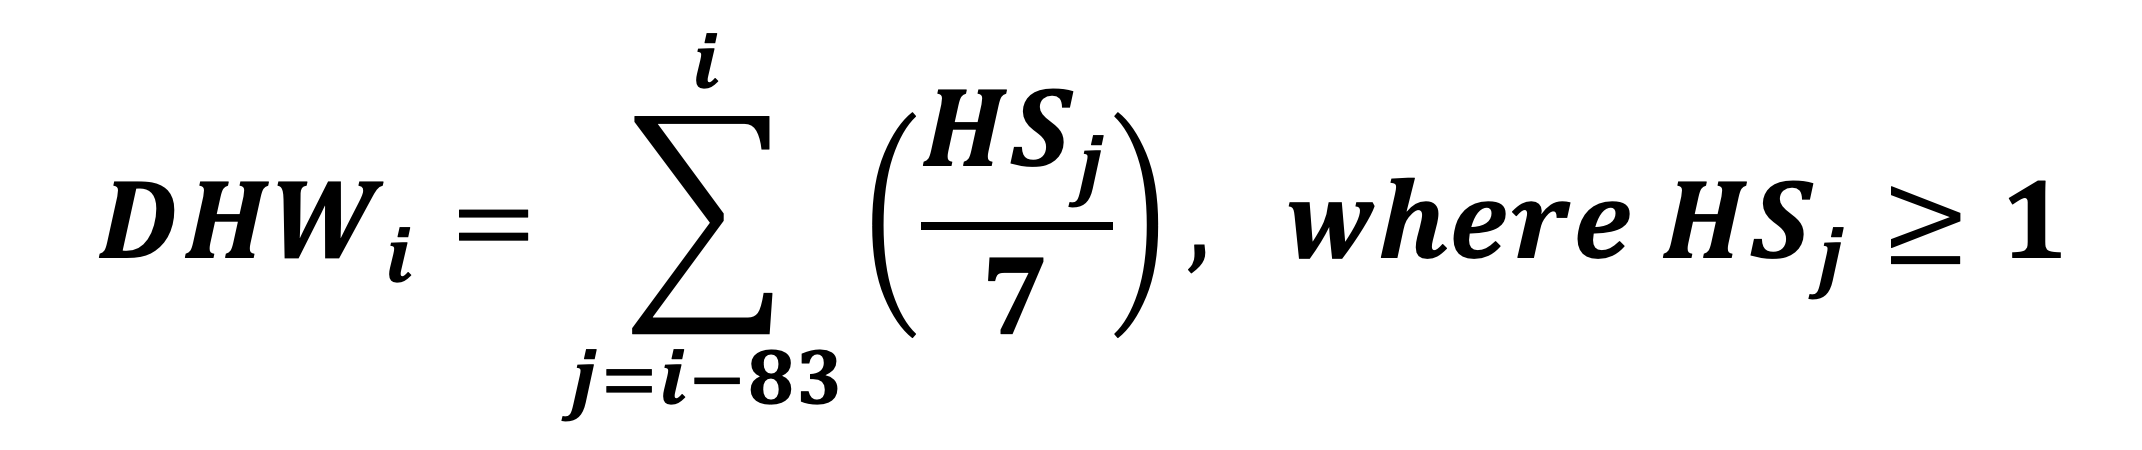

### calculate DHW in 2 ways: using the standard 1°C threshold and using the variability based threshold (2*MMMstd; Boylan & Kleypas 2008)

### First do North Puerto Rico

In [14]:
#set up empty dataset for DHW 
DHW1 = np.zeros((nday),dtype=float) #standard way (Coral reef watch)
DHW2 = np.zeros((nday),dtype=float) #variability-based way (
hotspot_anoms1 = np.zeros((nday),dtype=float)
hotspot_anoms2 = np.zeros((nday),dtype=float)

### the additional temperature threshold beyond climatological maximum that is included in DHM
threshold1 = 1
threshold2 = 2*MMMstd_NPR

### cycle through all the days
for d in range(0,nday):

    ### now calculate how much this day exceeds the threshold, otherwise anomaly is zero
    if ds.NPR_sst[d] > MMM_NPR + threshold1:
        hotspot_anoms1[d] = ds.NPR_sst[d] - (MMM_NPR + threshold1)

    if ds.NPR_sst[d] > MMM_NPR + threshold2:
        hotspot_anoms2[d] = ds.NPR_sst[d] - (MMM_NPR + threshold2)

### sum up DHW, start 84 days into the dataset since this is the DHW period
### cycle through all the days, summing over 12 weeks prior (84 days)

for d in range(84,nday):
    
    DHW1[d] = np.sum((hotspot_anoms1[d-84:d+1])/7)
    DHW2[d] = np.sum((hotspot_anoms2[d-84:d+1])/7)

### convert DHW to xarray and add it to the original dataset
ds['DHW1_NPR'] = xr.DataArray(DHW1,dims=('time'))
ds['DHW2_NPR'] = xr.DataArray(DHW2,dims=('time'))
ds['HS_anoms1_NPR'] = xr.DataArray(hotspot_anoms1,dims=('time'))
ds['HS_anoms2_NPR'] = xr.DataArray(hotspot_anoms2,dims=('time'))

### Now do South Puerto Rico

In [15]:
#set up empty dataset for DHW 
DHW1 = np.zeros((nday),dtype=float) #standard way (Coral reef watch)
DHW2 = np.zeros((nday),dtype=float) #variability-based way (
hotspot_anoms1 = np.zeros((nday),dtype=float)
hotspot_anoms2 = np.zeros((nday),dtype=float)

### the additional temperature threshold beyond climatological maximum that is included in DHM
threshold1 = 1
threshold2 = 2*MMMstd_SPR

### cycle through all the days
for d in range(0,nday):

    ### now calculate how much this day exceeds the threshold, otherwise anomaly is zero
    if ds.SPR_sst[d] > MMM_SPR + threshold1:
        hotspot_anoms1[d] = ds.SPR_sst[d] - (MMM_SPR + threshold1)

    if ds.SPR_sst[d] > MMM_SPR + threshold2:
        hotspot_anoms2[d] = ds.SPR_sst[d] - (MMM_SPR + threshold2)

### sum up DHW, start 84 days into the dataset since this is the DHW period
### cycle through all the days, summing over 12 weeks prior (84 days)

for d in range(84,nday):
    
    DHW1[d] = np.sum((hotspot_anoms1[d-84:d+1])/7)
    DHW2[d] = np.sum((hotspot_anoms2[d-84:d+1])/7)

### convert DHW to xarray and add it to the original dataset
ds['DHW1_SPR'] = xr.DataArray(DHW1,dims=('time'))
ds['DHW2_SPR'] = xr.DataArray(DHW2,dims=('time'))
ds['HS_anoms1_SPR'] = xr.DataArray(hotspot_anoms1,dims=('time'))
ds['HS_anoms2_SPR'] = xr.DataArray(hotspot_anoms2,dims=('time'))

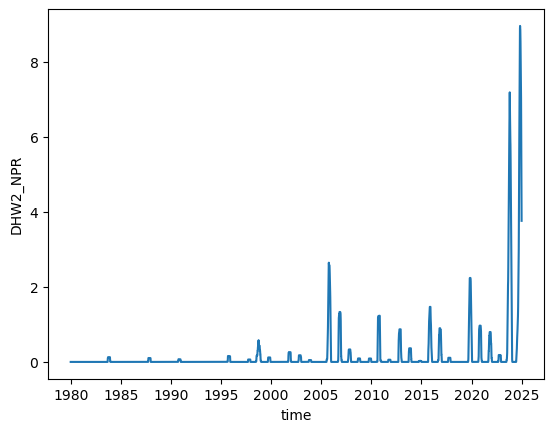

In [16]:
ds['DHW2_NPR'].plot()

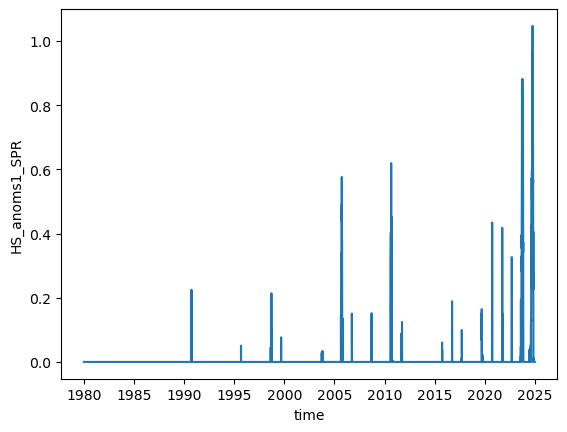

In [17]:
ds['HS_anoms1_SPR'].plot()

### Calculate max level of bleaching within each calendar year

This is where we can choose eith the standard 1°C bleaching threshold or a variability-based threshold (2*SD) for bleaching

In [19]:
nyear = 45

### first do North Puerto Rico

In [20]:

ds_bleach = xr.Dataset() #this dataset will have yearly time dim

In [30]:
### create empty arrays for bleaching indices, etc
bleach1 = np.zeros((nyear),dtype=int) 
bleach2 = np.zeros((nyear),dtype=int)
max_DHW_year1 = np.zeros((nyear),dtype=float)
max_DHW_year2 = np.zeros((nyear),dtype=float)
days_with_bleaching1 = np.zeros((nyear),dtype=int) #when DHW >= 4
days_with_bleaching2 = np.zeros((nyear),dtype=int) #when DHW >= 4


### cycle through all the years, calculating max DHW for that year, the max bleaching index, and the number of days with >4 DHWs

ts = 0 #yearly counter
i = 0 #daily counter

for y in np.arange(1980,2025,1):

    #specify number of days in this year (determine if it's a leap year)
    if y==1980 or y==1984 or y==1988 or y==1992 or y==1996 or y==2000 or y==2004 or y==2008 or y==2012 or y==2016 or y==2020 or y==2024:
        ndays = 366
    else:
        ndays=365

    ### find out max degree heating weeks for this particular year
    max_DHW_year1[ts] = np.max(ds.DHW1_NPR[i:i+ndays])
    max_DHW_year2[ts] = np.max(ds.DHW2_NPR[i:i+ndays])
    
    bleach1[ts] = int(max_DHW_year1[ts]/4)
    bleach2[ts] = int(max_DHW_year2[ts]/4)
    
    ### count of the number of days with a DHW >= 4
    days_with_bleaching1[ts] = np.count_nonzero(ds.DHW1_NPR[i:i+ndays] >= 4)
    days_with_bleaching2[ts] = np.count_nonzero(ds.DHW2_NPR[i:i+ndays] >= 4)
    
    i = i + ndays

    ts = ts + 1

ds_bleach['bleach_index_NPR1'] = xr.DataArray(bleach1, dims=('time'))
ds_bleach['bleach_index_NPR2'] = xr.DataArray(bleach2, dims=('time'))

ds_bleach['num_days_bleach_NPR1'] = xr.DataArray(days_with_bleaching1, dims=('time'))
ds_bleach['num_days_bleach_NPR2'] = xr.DataArray(days_with_bleaching2, dims=('time'))

ds_bleach['max_DHW_NPR1'] = xr.DataArray(max_DHW_year1, dims=('time'))
ds_bleach['max_DHW_NPR2'] = xr.DataArray(max_DHW_year2, dims=('time'))

#ds_bleach['time'] = np.arange(1995,2025,1)

In [31]:
ds_bleach

<xarray.Dataset>
Dimensions:               (time: 45)
Dimensions without coordinates: time
Data variables:
    bleach_index_NPR1     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 1
    bleach_index_NPR2     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 1 2
    num_days_bleach_NPR1  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 53
    num_days_bleach_NPR2  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 84 96
    max_DHW_NPR1          (time) float64 0.0 0.0 0.0 0.0 ... 0.0 2.487 4.516
    max_DHW_NPR2          (time) float64 0.0 0.002156 0.0 ... 0.1836 7.184 8.955

### Now do South Puerto Rico

In [32]:
### create empty arrays for bleaching indices, etc
bleach1 = np.zeros((nyear),dtype=int) 
bleach2 = np.zeros((nyear),dtype=int)
max_DHW_year1 = np.zeros((nyear),dtype=float)
max_DHW_year2 = np.zeros((nyear),dtype=float)
days_with_bleaching1 = np.zeros((nyear),dtype=int) #when DHW >= 4
days_with_bleaching2 = np.zeros((nyear),dtype=int) #when DHW >= 4


### cycle through all the years, calculating max DHW for that year, the max bleaching index, and the number of days with >4 DHWs

ts = 0 #yearly counter
i = 0 #daily counter

for y in range(1980, 2025,1):

    #specify number of days in this year (determine if it's a leap year)
    if y==1980 or y==1984 or y==1988 or y==1992 or y==1996 or y==2000 or y==2004 or y==2008 or y==2012 or y==2016 or y==2020 or y==2024:
        ndays = 366
    else:
        ndays=365

    ### find out max degree heating weeks for this particular year
    max_DHW_year1[ts] = np.max(ds.DHW1_SPR[i:i+ndays])
    max_DHW_year2[ts] = np.max(ds.DHW2_SPR[i:i+ndays])
    
    bleach1[ts] = int(max_DHW_year1[ts]/4)
    bleach2[ts] = int(max_DHW_year2[ts]/4)
    
    ### count of the number of days with a DHW >= 4
    days_with_bleaching1[ts] = np.count_nonzero(ds.DHW1_SPR[i:i+ndays] >= 4)
    days_with_bleaching2[ts] = np.count_nonzero(ds.DHW2_SPR[i:i+ndays] >= 4)
    
    i = i + ndays

    ts = ts + 1

ds_bleach['bleach_index_SPR1'] = xr.DataArray(bleach1, dims=('time'))
ds_bleach['bleach_index_SPR2'] = xr.DataArray(bleach2, dims=('time'))

ds_bleach['num_days_bleach_SPR1'] = xr.DataArray(days_with_bleaching1, dims=('time'))
ds_bleach['num_days_bleach_SPR2'] = xr.DataArray(days_with_bleaching2, dims=('time'))

ds_bleach['max_DHW_SPR1'] = xr.DataArray(max_DHW_year1, dims=('time'))
ds_bleach['max_DHW_SPR2'] = xr.DataArray(max_DHW_year2, dims=('time'))

ds_bleach['time'] = np.arange(1980,2025,1)

### Make some plots of the results

In [33]:
ds_bleach

<xarray.Dataset>
Dimensions:               (time: 45)
Coordinates:
  * time                  (time) int64 1980 1981 1982 1983 ... 2022 2023 2024
Data variables:
    bleach_index_NPR1     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 1
    bleach_index_NPR2     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 1 2
    num_days_bleach_NPR1  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 53
    num_days_bleach_NPR2  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 84 96
    max_DHW_NPR1          (time) float64 0.0 0.0 0.0 0.0 ... 0.0 2.487 4.516
    max_DHW_NPR2          (time) float64 0.0 0.002156 0.0 ... 0.1836 7.184 8.955
    bleach_index_SPR1     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 1 1
    bleach_index_SPR2     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 2 2
    num_days_bleach_SPR1  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 63 76
    num_days_bleach_SPR2  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 100 115
    max_DHW_SPR1          (time) float64 0.0 0.0 0.0 0.0 ... 0.3394 5.798 6.825
    max_DHW_SPR2          (time) float64 0.01337 0.3279 0.0 ... 9.485 10.77

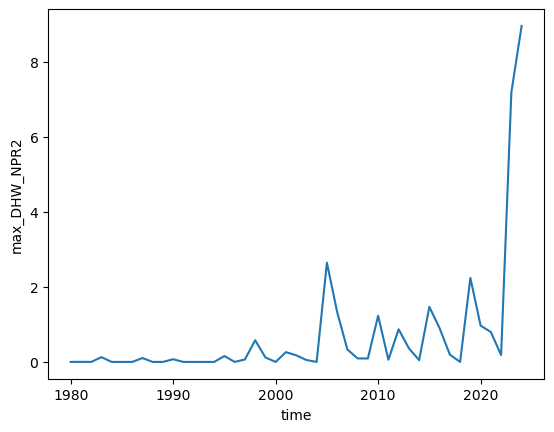

In [34]:
ds_bleach['max_DHW_NPR2'].plot()

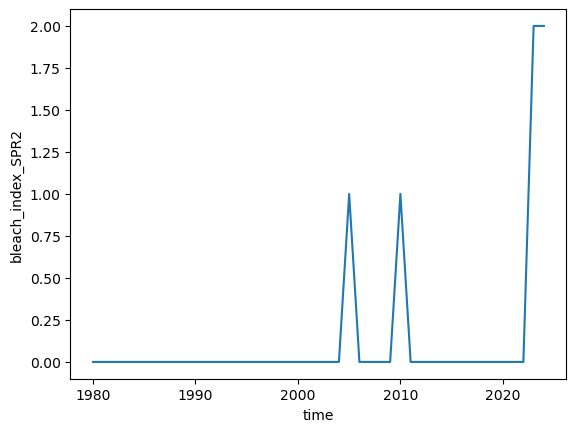

In [36]:
ds_bleach.bleach_index_SPR2.plot()

In [71]:
#colors = ['black','lightcoral','red','darkorange','gold','lightgreen','green','darkturquoise','dodgerblue','blue','darkviolet','magenta','hotpink']

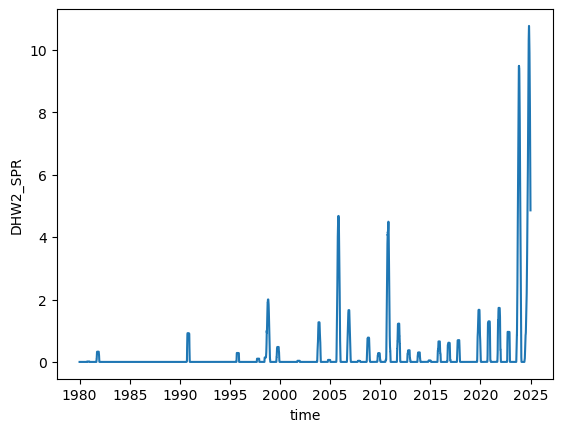

In [39]:
ds.DHW2_SPR.plot()

In [40]:
ds

<xarray.Dataset>
Dimensions:        (time: 16437)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2024-12-31
Data variables:
    SPR_sst        (time) float64 27.15 27.09 27.05 27.05 ... 28.48 28.39 28.43
    NPR_sst        (time) float64 25.99 25.9 25.87 25.91 ... 27.65 27.55 27.54
    DHW1_NPR       (time) float64 0.0 0.0 0.0 0.0 ... 2.429 2.314 2.195 2.082
    DHW2_NPR       (time) float64 0.0 0.0 0.0 0.0 0.0 ... 4.283 4.11 3.932 3.76
    HS_anoms1_NPR  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HS_anoms2_NPR  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    DHW1_SPR       (time) float64 0.0 0.0 0.0 0.0 ... 3.138 3.003 2.861 2.732
    DHW2_SPR       (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.401 5.22 5.031 4.856
    HS_anoms1_SPR  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HS_anoms2_SPR  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

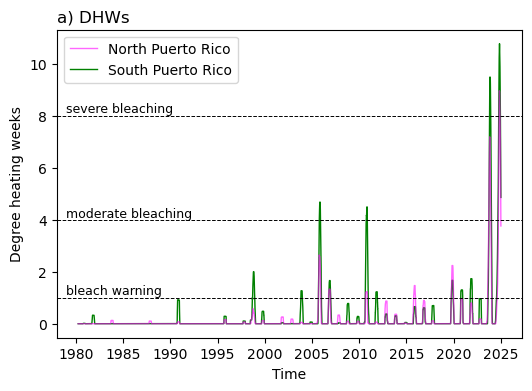

In [73]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.set_title('a) DHWs', loc='left')

ax.plot(ds.time.isel(time=slice(84,16437)),ds.DHW2_NPR.isel(time=slice(84,16437)),
        linewidth=1,label='North Puerto Rico',color='magenta',zorder=1,alpha=0.6)
ax.plot(ds.time.isel(time=slice(84,16437)),ds.DHW2_SPR.isel(time=slice(84,16437)),
        linewidth=1,label='South Puerto Rico',color='green',zorder=0)
ax.set(ylabel='Degree heating weeks',xlabel='Time')

ax.axhline(1,color='black',linewidth=0.7,linestyle='--')
ax.text(0.02,0.14,'bleach warning',fontsize=9, transform=ax.transAxes)
ax.axhline(4,color='black',linewidth=0.7,linestyle='--')
ax.text(0.02,0.39,'moderate bleaching',fontsize=9, transform=ax.transAxes)
ax.axhline(8,color='black',linewidth=0.7,linestyle='--')
ax.text(0.02,0.73,'severe bleaching',fontsize=9, transform=ax.transAxes)

ax.legend()

#fig.savefig('/glade/work/kristenk/figs/SPuerto_Rico_13LMEmems_900to1150.png', bbox_inches='tight', dpi=300, format='png');


In [74]:
ds.to_netcdf('/glade/derecho/scratch/kristenk/bleaching_work/daily_PR_DHWs.nc', mode='w')